# Dados do Setor de Saúde

Este notebook tem como objetivo analisar os indicadores mais importantes ou principais sobre o setor de saúde suplementar, sendo eles principalmente: sinistralidade, taxa de cobertura, número de operadores e VCHM.

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns

import src.demonstracoes_contabeis as dc

# options
pd.options.display.float_format = '{:.2f}'.format

## Sinistralidade

Segundo informações divulgada pela ANS, o cálculo da SINISTRALIDADE deve seguir a seguinte fórmula:

<br>

$$
Sinistralidade = \frac{\text{Eventos Indenizáveis Líquidos} + |CCT|}{\text{Receitas com Operações de Assistência a Saúde} + |CCT|}
$$

<br>

Essas informações nos demonstrativos contábeis correspondem aos códigos:

- Eventos Indenizáveis Líquidos - 41
- Receitas com Operações de Assistência a Saúde - 31
- Contraprestações de Corresponsabilidade Cedida (CCT) - 3117, 31171

In [41]:
data = dc.download_data(start_year=2018, end_year=2023)
data = data.drop(['DESCRICAO', 'VL_SALDO_INICIAL'], axis=1)

data.info()

/home/ian/Code/ipcap-hapvida/src/demonstracoes_contabeis.py:39: DtypeWarning: Columns (0,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f, sep=';', encoding='latin1', on_bad_lines='warn') for f in all_csv_files), ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096112 entries, 0 to 16096111
Data columns (total 4 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DATA               object 
 1   REG_ANS            float64
 2   CD_CONTA_CONTABIL  float64
 3   VL_SALDO_FINAL     object 
dtypes: float64(2), object(2)
memory usage: 491.2+ MB


In [42]:
# seleciona somente as linhas relevantes do demonstrativo contabil e aplica módulo
ans_contabil = data.loc[data['CD_CONTA_CONTABIL'].isin([3117, 31171, 41, 31])].copy()

ans_contabil['VL_SALDO_FINAL'] = ans_contabil['VL_SALDO_FINAL'].apply(lambda x: float(x.replace(',', '.')))
ans_contabil['VL_SALDO_FINAL'] = np.where(ans_contabil['CD_CONTA_CONTABIL'].isin([3117, 31171]), ans_contabil['VL_SALDO_FINAL'].abs(), ans_contabil['VL_SALDO_FINAL'])

ans_contabil.sample(10).reset_index(drop=True)

,DATA,REG_ANS,CD_CONTA_CONTABIL,VL_SALDO_FINAL
0,01/01/2018,311359.00,31.00,14090016.68
1,01/04/2018,419559.00,31.00,337155.49
2,01/01/2020,324175.00,31171.00,268918.07
3,01/01/2020,380661.00,3117.00,2596170.35
4,01/01/2020,402206.00,31.00,2965856.90
5,2022/01/01,406945.00,41.00,8290772.40
6,01/04/2019,421103.00,31.00,523714.26
7,01/04/2019,337374.00,3117.00,23015099.34
8,01/01/2021,418820.00,31171.00,1174234.78
9,2022-10-01,419354.00,41.00,5501223.38


In [43]:
# limpeza das datas no banco de dados
def parse_dates(str_date: str):
    for format in ('%Y-%m-%d', '%Y/%m/%d', '%d/%m/%Y'):
        try:
            return pd.to_datetime(str_date, format=format)
        except ValueError:
            continue
    return pd.NaT

ans_contabil['DATA'] = ans_contabil['DATA'].apply(parse_dates)

months = ans_contabil['DATA'].dt.month
years = ans_contabil['DATA'].dt.year

cond = [months == 1, months == 4, months == 7, months == 10]
labels = ['1T' + years.astype(str), '2T' + years.astype(str), '3T' + years.astype(str), '4T' + years.astype(str)]

ans_contabil['TRIMESTRE'] = np.select(cond, labels, default=None)
ans_contabil['DATA'] = ans_contabil['DATA'].dt.year

ans_contabil = ans_contabil.rename(columns={'DATA': 'ANO'})

ans_contabil.sample(10).reset_index(drop=True)

,ANO,REG_ANS,CD_CONTA_CONTABIL,VL_SALDO_FINAL,TRIMESTRE
0,2019,382876.00,31.00,406691446.35,1T2019
1,2018,406414.00,31.00,830.00,4T2018
2,2019,413330.00,41.00,27624690.28,3T2019
3,2023,342386.00,41.00,13211736.57,2T2023
4,2020,369411.00,3117.00,566119.35,1T2020
5,2019,357910.00,31.00,41260.18,4T2019
6,2019,314587.00,31171.00,5385507.38,2T2019
7,2018,319350.00,31.00,3874500.19,4T2018
8,2023,421766.00,41.00,5047668.55,1T2023
9,2021,306398.00,31.00,482194937.54,4T2021


In [47]:
# pivot

ans_pivot = ans_contabil.pivot_table(index=['ANO', 'TRIMESTRE'], columns='CD_CONTA_CONTABIL', values='VL_SALDO_FINAL', aggfunc='sum').reset_index()

ans_pivot[3117] = ans_pivot[3117] + ans_pivot[31171]
ans_pivot = ans_pivot.drop(31171, axis=1)

ans_pivot = ans_pivot.rename(columns={3117: 'CCT', 31: 'RECEITAS', 41: 'DESPESAS'})
ans_pivot.columns.name = None

ans_pivot.head(10)

,ANO,TRIMESTRE,RECEITAS,DESPESAS,CCT
0,2018,1T2018,46791009228.92,37165212903.12,652369922.15
1,2018,2T2018,97594706736.35,79185599222.05,1399877660.67
2,2018,3T2018,148763653728.05,121203254896.96,2385978688.01
3,2018,4T2018,200361597618.61,161469397459.17,23368620645.86
4,2019,1T2019,52091776233.95,40501045971.77,5908237235.52
5,2019,2T2019,104088433700.76,83388105622.49,12950938692.38
6,2019,3T2019,161125689305.31,130776315585.45,22705704802.02
7,2019,4T2019,216650014124.57,174539061631.06,33611312183.06
8,2020,1T2020,56500059157.66,43357020234.91,7819773060.08
9,2020,2T2020,112165488755.88,78167388881.27,14236063724.66


In [52]:
ans_pivot['SINISTRALIDADE'] = (ans_pivot['DESPESAS'] + ans_pivot['CCT']) / (ans_pivot['RECEITAS'] + ans_pivot['CCT'])

ans_pivot['SINISTRALIDADE'].mean()

0.8205049345684782

In [50]:
ans_pivot['SINISTRALIDADE'].where(ans_pivot['TRIMESTRE'] == '2T2023').dropna()

21   0.85
Name: SINISTRALIDADE, dtype: float64

<Axes: xlabel='ANO', ylabel='SINISTRALIDADE'>

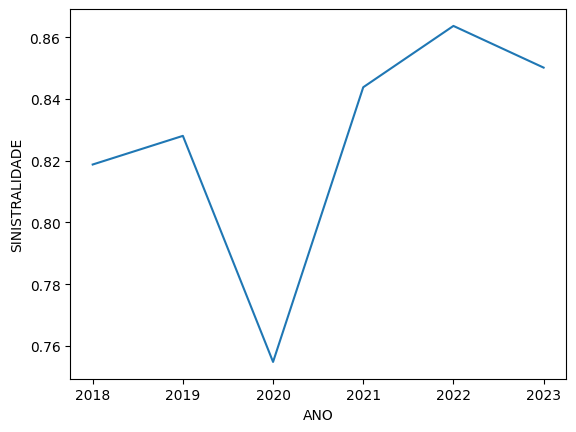

In [46]:
ans_pivot['ANO'] = ans_pivot['ANO'].astype(int)
sns.lineplot(data=ans_pivot, x='ANO', y='SINISTRALIDADE')
